In [155]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
# import PTMCMCSampler


import numpy as np

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import numpyro
from numpyro import distributions as dist, infer
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
# psrname = 'J1643-1224'
psrname = 'J1909-3744'
# maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
maindir = '../'
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/[JB]*-12p5.feather'))]
Tspan_pta = ds.getspan(psrs)
print(Tspan_pta / 365.25 / 86400)
names = [psr.name for psr in psrs]
idx = names.index(psrname)
psr = psrs[idx]
Tspan_psr = ds.getspan([psr])
n_rn_freqs = 30

12.915331060702131


In [157]:
# for injection purposes
import json
noisedict = json.load(open('../data/channelized_12p5yr_v3_full_noisedict.json', 'r'))
psrl = ds.PulsarLikelihood([psr.residuals,
                        ds.makenoise_measurement(psr, noisedict, tnequad=True),
                        ds.makegp_ecorr(psr, noisedict),
                        ds.makegp_timing(psr, variance=1e-19),
                        ds.makegp_fourier(psr, ds.freespectrum, n_rn_freqs, T=Tspan_psr, name='red_noise')])

In [158]:
freqs = jnp.arange(1, n_rn_freqs + 1) / Tspan_psr
logf = jnp.log(freqs)
npoints_interp = n_rn_freqs - 2

    # Precompute A and its inverse
b_0 = -6
b_last = -9
Ai, b_0_coeff, b_last_coeff = lncass_models.create_amatrix(npoints_interp, logf, cond=0)
Ai_nn, _, _ = lncass_models.create_amatrix_no_norm(npoints_interp, logf, cond=0)

# create injection
bvec = np.r_[b_0_coeff*b_0, np.zeros(npoints_interp - 2), b_last_coeff*b_last]
bvec[4] = 3
injection = np.r_[b_0, Ai @ bvec, b_last]

# Injection

Perform an injection from our interplation model. The injection itself was created 3 cells ago, we plot it below and use `discovery` to create fake residuals using white noise and timing model parameters from the pulsar we chose at the top, and the injected red noise.

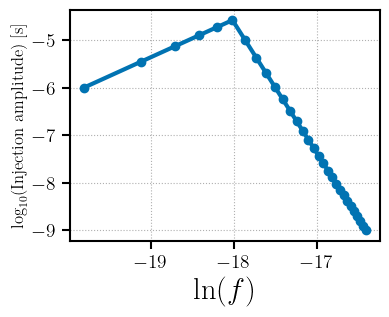

In [159]:
plt.plot(logf, injection, '-o')
plt.xlabel("$\\ln(f)$")
plt.ylabel("$\\log_{10}$(Injection amplitude) [s]", fontsize=12)
plt.show()

In [160]:
# create residuals
residuals = psrl.sample(jax.random.PRNGKey(101), {f'{psrname}_red_noise_log10_rho(30)': injection})
print(residuals[1])

[4.21783880e-05 4.21582750e-05 4.39385841e-05 ... 4.26194215e-05
 4.34478654e-05 4.41357186e-05]


In [161]:
# set our pulsars residuals to the injection
psr.residuals = np.array(residuals[1])

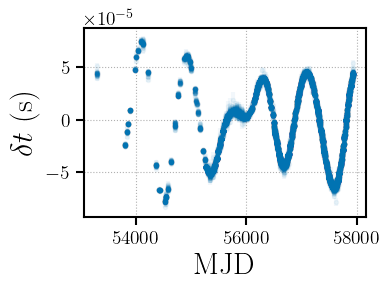

In [162]:
# plot new residuals
plt.errorbar(psr.toas / 86400, psr.residuals, yerr=psr.toaerrs, fmt='.', alpha=0.05)
plt.xlabel("MJD")
plt.ylabel("$\\delta t$ (s)")
plt.tight_layout()
plt.savefig("../plots/broken_powerlaw_residuals.pdf")
plt.show()

In [163]:
# set psr noisedict because for 12.5 year data,
# I didn't save it in the pulsar feather files
psr.noisedict = noisedict

In [164]:
# create the discovery model (gl) and the numpyro model for sampling (model)
model, gl = lncass_models.create_rn_single_psr_model(psr, n_rn_freqs, cond=0, tnequad=True)

In [165]:
jlogl = jax.jit(gl.logL)

In [166]:
%%timeit
jlogl({f'{psrname}_red_noise_log10_rho(30)': injection})

85.5 μs ± 12.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [168]:
# set up the sampler
# we set target_accept_prob=0.99, which is quite high.
# But I was getting a reasonable number of divergences when I didn't set it this high,
# and this has significantly reduced the percentage of divergences from ~25% down to ~0.5%
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10,dense_mass=False,
    forward_mode_differentiation=False, target_accept_prob=0.99),
    num_warmup=5000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

prior_dict = {**PRIOR_DICT, 'tau': dist.Uniform(4.999, 5.),
              'sigma_lambda':dist.Uniform(4.999, 5.001),
              'mu_lambda': dist.Uniform(-50, 50)}
# lncass_outliers_sampler = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=200, chain_method='vectorized')
lncass_outliers_sampler.run(jax.random.PRNGKey(0), prior_dict=prior_dict)

sample: 100%|██████████| 6000/6000 [21:29<00:00,  4.65it/s, 1023 steps of size 4.07e-03. acc. prob=0.99]


In [169]:
samples = lncass_outliers_sampler.get_samples()

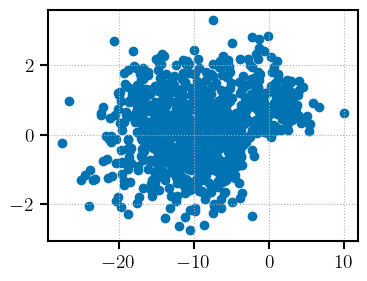

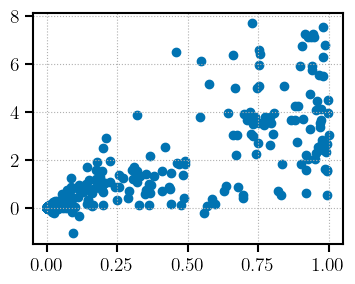

In [170]:
plt.scatter(samples['lambda_tilde_rn'][:, 0], samples['beta_xi_rn'][:, 0])
plt.show()

plt.scatter(samples['lambdas_rn'][:, 0], samples['beta_rn'][:, 0])
plt.show()

In [171]:
lncass_outliers_sampler.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_xi_rn[0]      0.20      0.99      0.27     -1.42      1.81    792.42      1.00
      beta_xi_rn[1]      0.00      0.93      0.01     -1.45      1.60   1568.53      1.00
      beta_xi_rn[2]      0.00      1.02     -0.01     -1.63      1.65   2204.40      1.00
      beta_xi_rn[3]      0.13      1.06      0.17     -1.85      1.57    571.61      1.00
      beta_xi_rn[4]      0.98      0.63      0.85      0.32      2.14    210.27      1.00
      beta_xi_rn[5]     -0.01      0.96      0.03     -1.49      1.58   1677.93      1.00
      beta_xi_rn[6]      0.03      0.99      0.03     -1.63      1.62   1801.67      1.00
      beta_xi_rn[7]     -0.02      0.98     -0.02     -1.59      1.50   2217.43      1.00
      beta_xi_rn[8]     -0.00      0.99      0.03     -1.83      1.48   1654.42      1.00
      beta_xi_rn[9]     -0.01      0.95      0.02     -1.60      1.55   1547.77      1.00
     beta

In [172]:
# import arviz as az
# idata = az.from_numpyro(
#                     lncass_outliers_sampler
#                     )

In [173]:
# az.plot_pair(idata, divergences=True, var_names=['beta_rn', 'mu_lambda_rn'])

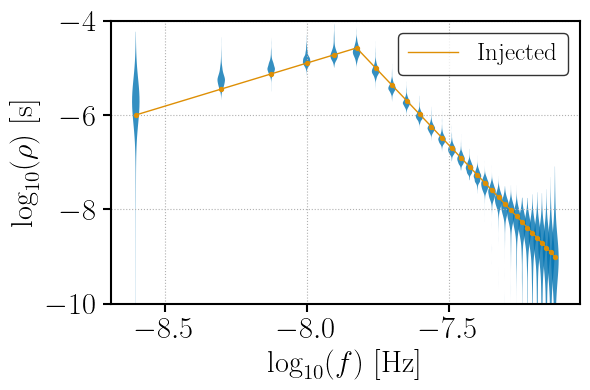

In [174]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for b in parts['bodies']:
    b.set_alpha(0.8)
# plt.plot(np.log10(freqs),  , '-o', lw=1)
plt.plot(np.log10(freqs), injection, '-', lw=1, label='Injected', zorder=100)
plt.scatter(np.log10(freqs), injection, s=8, zorder=100, c='C1')
# plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.ylim(-10, -4)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

In [175]:
samples['lambdas_rn'].shape

(1000, 28)

In [176]:
# n_betas = np.sum(samples['lambdas_rn'] > 0.5, axis=1)
# all_betas_zero_indexes = np.where(n_betas==0)[0]
# print(samples['lambdas_rn'][all_betas_zero_indexes, 4])
# # print(samples['sigma_lambda_rn'][all_betas_zero_indexes])
# plt.figure(figsize=(24, 12))
# # parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
# for idx in all_betas_zero_indexes:
#     plt.plot(np.log10(freqs), samples['log10_rho'][idx],  lw=1, alpha=0.1, c='r')
# plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=100)
# plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
# plt.xlabel("$\log_{10}(f)$ [Hz]")
# plt.ylabel("$\log_{10}(\\rho)$ [s]")
# plt.ylim(-10, -4)
# plt.legend()
# # plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
# plt.show()

In [177]:
# plt.figure(figsize=(24, 12))
# # parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
# for ii in range(1000):
#     plt.plot(np.log10(freqs), samples['log10_rho'][ii],  lw=1, alpha=0.1, c='r')
# plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=100)
# plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
# plt.xlabel("$\log_{10}(f)$ [Hz]")
# plt.ylabel("$\log_{10}(\\rho)$ [s]")
# plt.ylim(-10, -4)
# plt.legend()
# # plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
# plt.show()

In [178]:
import pandas as pd
pandas_dict = {}
pandas_dict['amplitude'] = []
pandas_dict['frequency'] = []
for ii,col in enumerate(samples['beta_rn'].T):
    pandas_dict['amplitude'].extend(samples['beta_rn'][:, ii].tolist())
    pandas_dict['frequency'].extend((np.log10(freqs[ii]) * np.ones_like(samples['beta_rn'][:, ii])).tolist())
df = pd.DataFrame(pandas_dict)

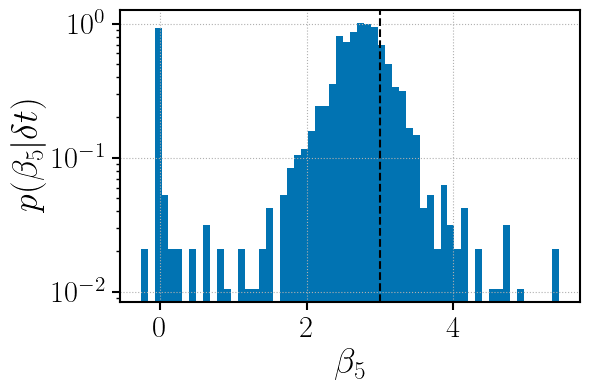

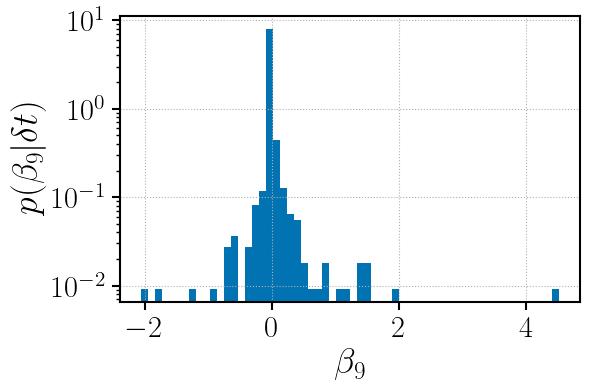

5.756756756756757


In [179]:
plt.figure(figsize=(6, 4))
plt.hist(samples['beta_rn'][:, 4], bins=60, density=True)
plt.xlabel("$\\beta_5$", fontsize=26)
plt.ylabel('$p(\\beta_5 | \\delta t)$', fontsize=26)
ax = plt.gca()
ax.axvline(3, c='k', linestyle='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.yscale("log")
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_beta_5_example.pdf")

plt.figure(figsize=(6, 4))
plt.hist(samples['beta_rn'][:, 8], bins=60, density=True)
plt.xlabel("$\\beta_9$", fontsize=26)
plt.ylabel('$p(\\beta_9 | \\delta t)$', fontsize=26)
ax = plt.gca()
# ax.axvline(3, c='k', linestyle='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.yscale("log")
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_beta_9_example.pdf")

plt.show()
print(np.sum(samples['lambdas_rn'][:, 4] > 0.25) / np.sum(samples['lambdas_rn'][:, 4] < 0.25))


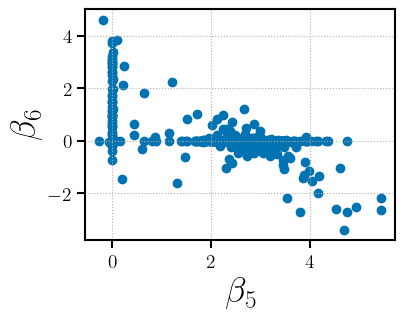

In [180]:
plt.scatter(samples['beta_rn'][:, 4], samples['beta_rn'][:, 5])
plt.xlabel("$\\beta_5$", fontsize=26)
plt.ylabel("$\\beta_6$", fontsize=26)
plt.show()

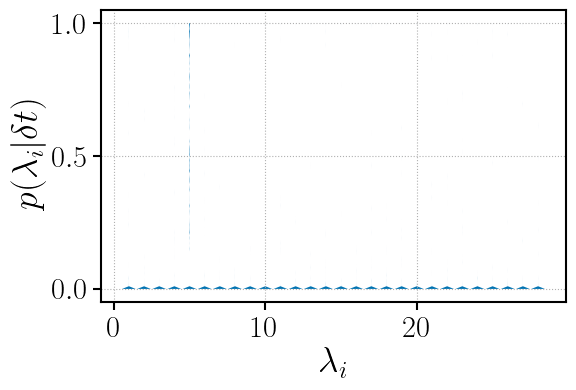

In [181]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['lambdas_rn'], showextrema=False, bw_method=0.001, widths=0.9)
for b in parts['bodies']:
    b.set_alpha(1)
plt.xlabel("$\lambda_i$", fontsize=26)
plt.ylabel("$p(\lambda_i | \delta t)$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_lambda_posteriors.pdf")
plt.show()

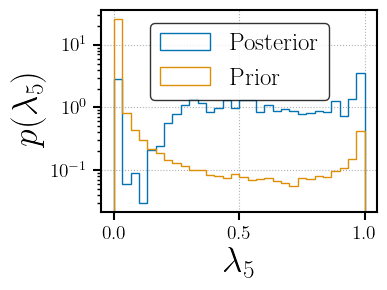

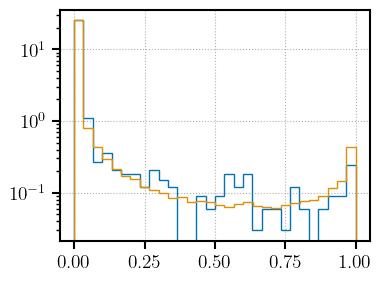

0.07142857142857142


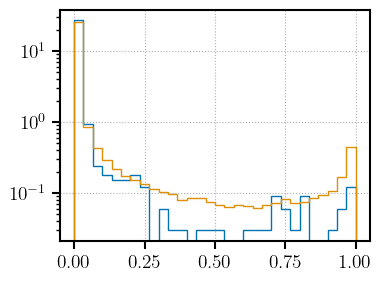

In [182]:
plt.hist(samples['lambdas_rn'][:, 4], bins=30, histtype='step', density=True, label='Posterior')

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
plt.hist(lam_prior_vals[:, 4], density=True, bins=30, histtype='step', label='Prior')
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.xlabel("$\lambda_5$", fontsize=26)
plt.ylabel("$p(\lambda_5)$", fontsize=26)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_lambda_5_posterior_and_prior.pdf")
plt.show()


plt.hist(samples['lambdas_rn'][:, 5], bins=30, histtype='step', density=True)

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
plt.hist(lam_prior_vals[:, 5], density=True, bins=30, histtype='step')
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.show()

plt.hist(samples['lambdas_rn'][:, 10], bins=30, histtype='step', density=True)

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
n, bins, patches = plt.hist(lam_prior_vals[:, 10], density=True, bins=30, histtype='step')
print(np.sum(n > 0.5) / np.sum(n < 0.5))
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.show()

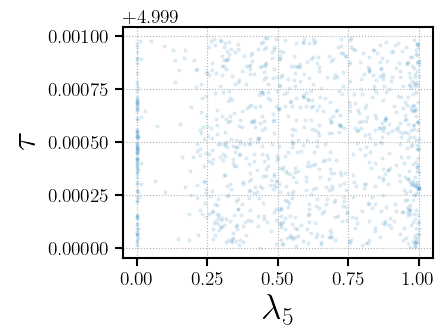

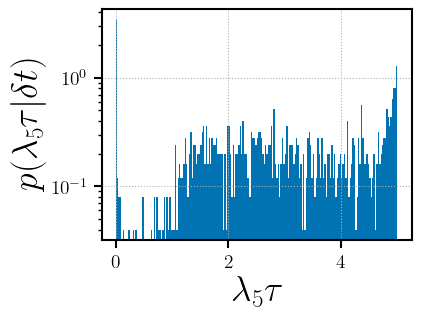

In [183]:
plt.scatter(samples['lambdas_rn'][:, 4], samples['tau_rn'], alpha=0.1, s=4)
plt.xlabel("$\lambda_5$", fontsize=26)
plt.ylabel("$\\tau$", fontsize=26)
plt.show()

plt.hist(samples['lambdas_rn'][:, 4] * samples['tau_rn'], bins=200, density=True)
plt.xlabel("$\lambda_5 \\tau$", fontsize=26)
plt.ylabel("$p(\lambda_5 \\tau | \delta t)$", fontsize=26)
plt.yscale("log")
# plt.xlim(0, 0.5)
plt.show()

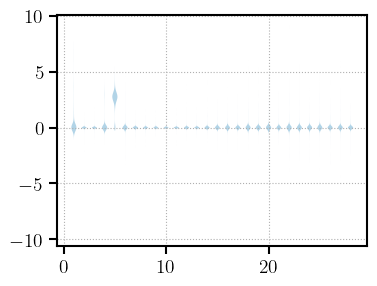

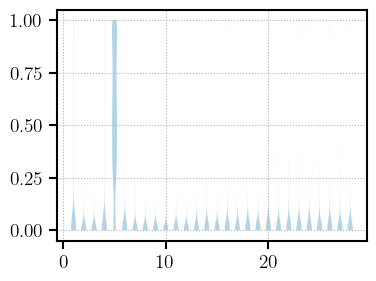

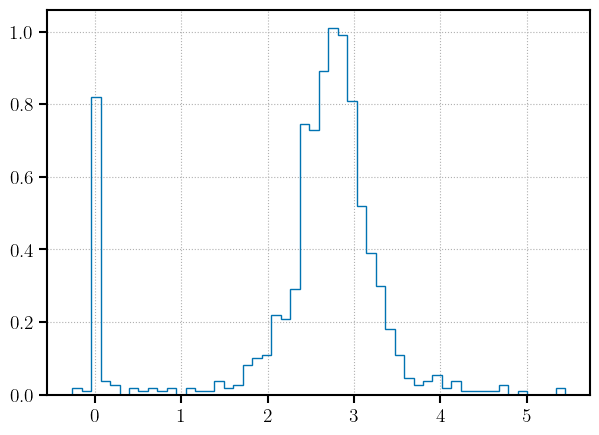

In [184]:
plt.violinplot(samples['beta_rn'], showextrema=False)
plt.show()
plt.violinplot(samples['lambdas_rn'], showextrema=False)
plt.show()
plt.figure(figsize=(7, 5))
bins='auto' # np.linspace(-3, 3, num=100)
plt.hist(samples['beta_rn'][:, 4], bins=bins, histtype='step', density=True)
plt.show()
# plt.hist(samples['beta_rn'][:, 5], bins=bins, histtype='step', density=True)
# plt.hist(samples['beta_rn'][:, 20], bins=bins, histtype='step', density=True)
# plt.yscale("log")
plt.show()
# plt.hist(samples['lambdas_rn'][:, 4], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# plt.hist(samples['lambdas_rn'][:, 5], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# n, bins, patches = plt.hist(samples['lambdas_rn'][:, 20], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# print(n[0] / n[-1])

In [185]:
pinc = np.clip((samples['lambdas_rn'][:, 4] > 0.1).astype(int) + (samples['lambdas_rn'][:, 3] > 0.5).astype(int) + (samples['lambdas_rn'][:, 5] > 0.5).astype(int), 0, 1).mean()
print(pinc / (1 - pinc))

33.48275862068962


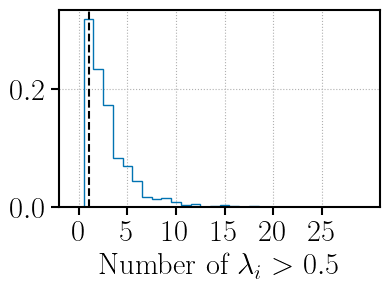

In [186]:
n, bins, patches = plt.hist(np.sum(samples['lambdas_rn'] > 0.1, axis=1), bins=np.arange(0, 31)-0.5, histtype='step', density=True)
plt.xlabel("Number of $\\lambda_i > 0.5$")
ax = plt.gca()
ax.axvline(1, c='k', ls='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.xticks(np.arange(0, 30, 5))
plt.tight_layout()
# plt.yscale("log")
plt.savefig("../plots/single_pulsar_broken_powerlaw_number_of_nodes.pdf")
plt.show()


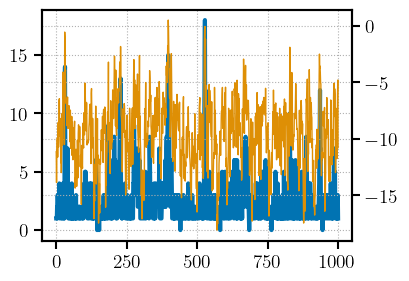

In [187]:
plt.plot(np.sum(samples['lambdas_rn'] > 0.2, axis=1))
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(samples['mu_lambda_rn'], c='C1', lw=1)
plt.show()

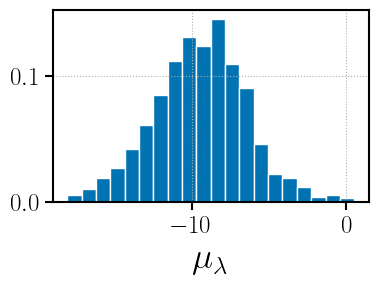

In [188]:
plt.hist(samples['mu_lambda_rn'], bins=20, density=True, edgecolor='w')
plt.xlabel("$\mu_\lambda$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_mu_lambda.pdf")
plt.show()

In [189]:
from scipy.special import expit
def plot_lncass_priors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    axes = axes.ravel()
    # histogram sigma_lambda_rn
    axes[0].hist(samples[f'sigma_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[0].set_title(f'$\\sigma_{{\\lambda_{{ {tag} }}}}$')
    # histogram mu_lambda_rn
    axes[1].hist(samples[f'mu_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[1].set_title(f'$\\mu_{{\\lambda_{{ {tag} }}}}$')
    # get prior on b's
    lam_prior_vals = []
    b_prior_vals = []
    for ii in range(1000):
        idx = np.random.randint(0, samples[f'tau_{tag}'].shape[0])
        lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_{tag}'][idx] + samples[f'mu_lambda_{tag}'][idx])
        lam_prior_vals.extend(lam_prior.tolist())
        bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_{tag}'][idx]
        b_prior_vals.extend(bvals)
    lam_prior_vals = np.array(lam_prior_vals)

    b_prior_vals = np.array(b_prior_vals)
    axes[2].hist(lam_prior_vals.flatten(), bins=50, density=True, histtype='step', color='b', alpha=0.5)
    axes[2].set_title(f'$\\lambda_{{ {tag} }}$ Prior')
    axes[2].set_yscale("log")
    # axes[2].set_xscale("log")
    axes[3].hist(b_prior_vals.flatten(), bins=200, density=True, histtype='step', color='b', alpha=0.5)
    axes[3].set_yscale("log")
    # axes[3].set_ylim(0, )
    axes[3].set_title(f'$b_{{ {tag} }}$ Prior')
    plt.tight_layout()
    plt.show()

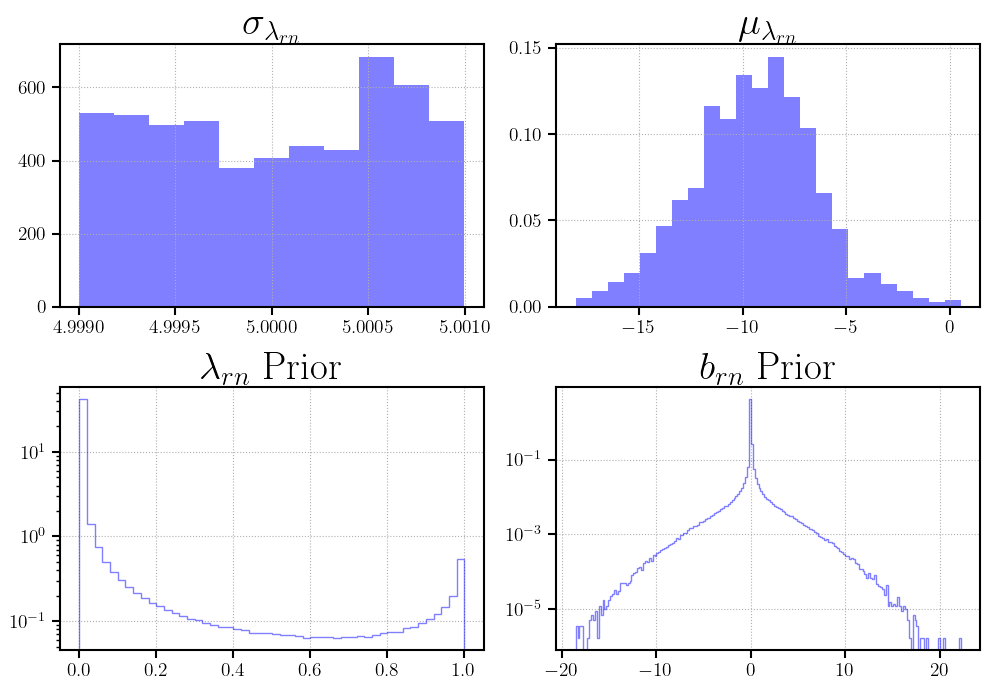

In [190]:
plot_lncass_priors(samples)
# plot_lncass_priors(samples, tag='o')


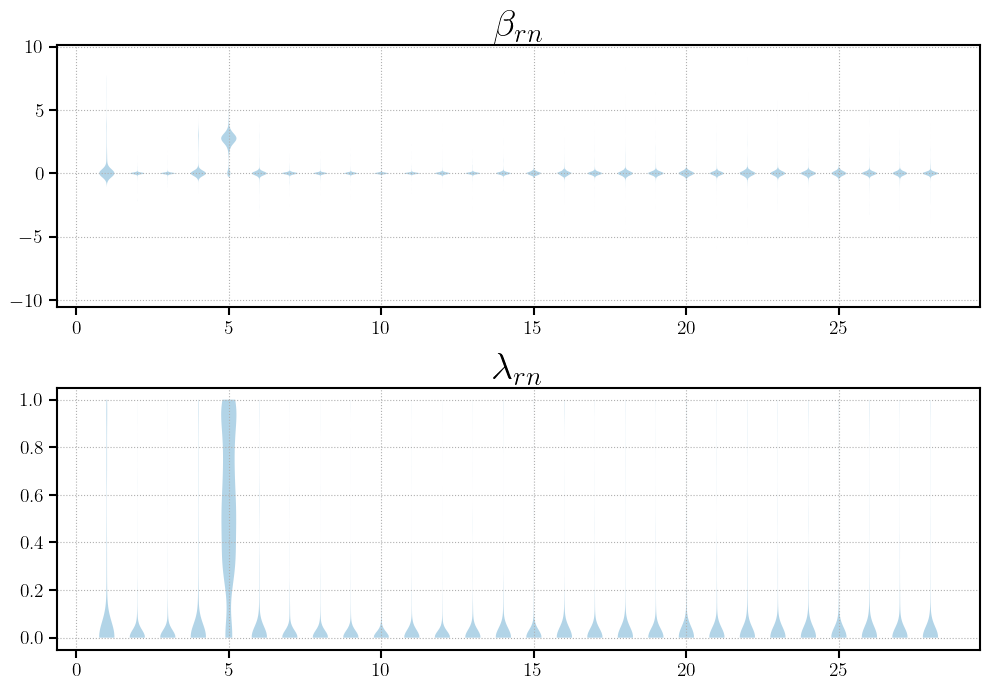

In [191]:

import matplotlib.gridspec as gridspec

def plot_lncass_posteriors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    axes = axes.ravel()
    axes[0].violinplot(samples[f'beta_{tag}'], showextrema=False)
    axes[0].set_title(f'$\\beta_{{ {tag} }}$')
    
    axes[1].violinplot(samples[f'lambdas_{tag}'], showextrema=False)
    axes[1].set_title(f'$\\lambda_{{ {tag} }}$')
    
    plt.tight_layout()
    plt.show()

plot_lncass_posteriors(samples)
# plot_lncass_posteriors(samples, tag='o')

# Other Samplers


In [114]:
from numpyro_ext import optim as optimx
# pat = optimx.JAXOptMinimize(maxiter=1000)

In [118]:
soln = optimx.optimize(model, return_info=True, num_steps=1)(jax.random.PRNGKey(101), prior_dict=prior_dict)

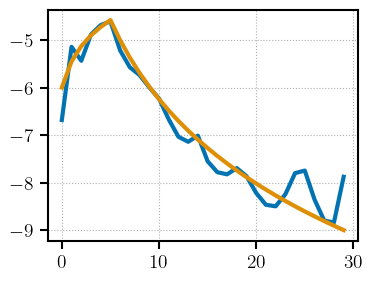

In [120]:
plt.plot(soln[0]['log10_rho'])
plt.plot(injection)

In [147]:

# barker_sampler = infer.MCMC(
#     infer.BarkerMH(model,dense_mass=True, target_accept_prob=0.95),
#     num_warmup=20_000,
#     num_samples=10_000,
#     num_chains=1,
#     progress_bar=True,chain_method='vectorized'
# )

kernel = infer.SA(model)

aies_sampler = infer.MCMC(
    kernel,
    num_warmup=100000,
    num_samples=5000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [148]:
print(jnp.repeat(soln[0]['log10_rho'], 100).reshape(30, 100)[:, 0])


[-6.68257293 -5.14311267 -5.43652834 -4.88278485 -4.68604646 -4.60628553
 -5.22031871 -5.57372404 -5.73790821 -5.99734805 -6.23226041 -6.66923387
 -7.03709545 -7.1416039  -7.01268259 -7.55035018 -7.78153926 -7.8267903
 -7.69481586 -7.86495756 -8.2189445  -8.46741963 -8.49961228 -8.24717428
 -7.80135658 -7.74768715 -8.35570056 -8.80054684 -8.83929755 -7.87834634]


In [149]:
prior_dict = {**PRIOR_DICT, 'tau': dist.Uniform(4.999, 5.),
              'sigma_lambda':dist.Uniform(4.999, 5.001),
              'mu_lambda': dist.Uniform(-50, 50)}
# lncass_outliers_sampler = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=200, chain_method='vectorized')
aies_sampler.run(jax.random.PRNGKey(0), prior_dict=prior_dict, init_params={f'{psrname}_red_noise_log10_rho(30)': soln[0]['log10_rho']})

sample: 100%|██████████| 105000/105000 [12:48<00:00, 136.65it/s, acc. prob=0.00]


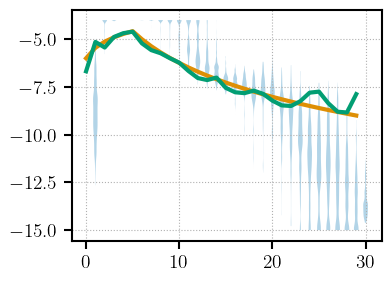

In [145]:
samples_barker = aies_sampler.get_samples()
plt.violinplot(samples_barker['log10_rho'].squeeze(), showextrema=False)
plt.plot(injection)
plt.plot(soln[0]['log10_rho'])
plt.show()

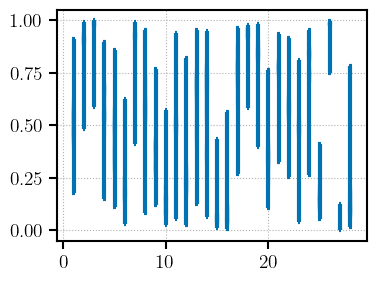

In [146]:
plt.violinplot(samples_barker['lambdas_rn'].squeeze())
plt.show()

In [154]:
# from numpyro.contrib.tfp.mcmc import TFPKernel
import tensorflow_probability as tfp

kernel_test = TFPKernel[tfp.mcmc.NoUTurnSampler](model, step_size=1.)





Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




ModuleNotFoundError: No module named 'tf_keras'

# Power law

In [ ]:
pl_model = lncass_models.create_single_psr_powerlaw_model(psr, n_rn_freqs)
pl_sampler = infer.MCMC(
    infer.NUTS(pl_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    pl_sampler.run(jax.random.PRNGKey(13))

In [ ]:
pl_sampler.print_summary()

In [ ]:
fspec_model = lncass_models.create_single_psr_freespec_model(psr, n_rn_freqs)
fspec_sampler = infer.MCMC(
    infer.NUTS(fspec_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    fspec_sampler.run(jax.random.PRNGKey(13))

In [ ]:
fspec_sampler.print_summary()

In [ ]:
fspec_samples = fspec_sampler.get_samples()
pl_samples = pl_sampler.get_samples()

In [ ]:
pl_samples.keys()

In [ ]:
freqs = np.arange(1, 31) / ds.getspan([psr])
fyr = 1 / 365.25 / 86400
pl_rhos = np.array([np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2  for idx in range(1000)])

In [ ]:
pl_rhos.shape

In [ ]:
plt.figure(figsize=(10, 4))
plt.violinplot(fspec_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
freqs = np.arange(1, 31) / ds.getspan([psr])
plt.plot(np.arange(1, n_rn_freqs+1), injection, '-o', lw=1)

plt.ylim(-8, -4)

for ii in range(500):
    idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
    tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
    plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)

# Direct deviation from power law

In [ ]:
spline_model = lncass_models.create_rn_single_psr_spline_model(psr, n_rn_freqs, 20)
spline_sampler = infer.MCMC(
    infer.NUTS(spline_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    spline_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT})

In [ ]:
spline_sampler.print_summary()

In [ ]:
spline_samples = spline_sampler.get_samples()

In [ ]:
plt.figure(figsize=(10, 8))
plt.violinplot(spline_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
# plt.violinplot(pl_rhos, showextrema=False, side="high", widths=0.9)
plt.ylim(-8, -2)
plt.plot(np.arange(1, n_rn_freqs+1),  injection, '-o')
# for ii in range(1000):
#     idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
#     tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
#     plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)
plt.show()

In [ ]:
plt.violinplot(spline_samples['beta_rn'].squeeze(), showextrema=False, widths=0.9)
plt.ylim(-2, 2)
plt.show()